In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
from matplotlib import pyplot as plt
from implementations import *

#to access our implemented ML functions
%load_ext autoreload
%autoreload 2

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
rng = np.random.default_rng(2022)

### We will cut the data into different energy ranges but which ?

In [3]:
data_path = data_file(20.0)

In [4]:
data = clean_df(build_df(data_path))

In [5]:
print(data.shape)

(721043, 18)


In [6]:
data.head()

,index,X(mm),Y(mm),Z(mm),DX,DY,DZ,KinE(MeV),dE(MeV),StepLeng,X(mm)_s,Y(mm)_s,Z(mm)_s,DX_s,DY_s,DZ_s,Kin(MeV)_s,name_s
0,0,0.00,100.0,100.0,1.000,0.000,0.00000,20.0,0.000,0.00,0.00,0.0,0.0,0.000,0.000,0.0000,0.000,0
1,1,4.12,99.8,100.0,0.987,-0.160,-0.01220,18.4,0.563,4.12,4.12,99.8,100.0,0.802,0.592,0.0804,1.070,e-
2,2,8.26,99.1,100.0,0.974,-0.227,-0.01810,17.6,0.621,4.22,8.26,99.1,100.0,0.506,0.811,-0.2930,0.119,e-
3,3,12.90,98.2,100.0,0.983,-0.184,0.00546,16.8,0.779,4.78,0.00,0.0,0.0,0.000,0.000,0.0000,0.000,0
4,4,14.60,97.8,100.0,0.937,-0.331,0.10700,11.6,0.311,1.69,14.60,97.8,100.0,0.987,0.133,-0.0869,4.890,e-


We can add the cosines as we need to predict this parameter

In [8]:
data = get_cos_theta(data)

In [9]:
print(data.shape) #20 000 less than before since we don't have the values of cosine for the last value of each electron

(701043, 19)


Now, we will try different energy ranges and see what fits the most the necessary predictions.

In [10]:
data['E_range'] = 0

In [11]:
data = data[data['index'] != 0]

In [12]:
energy_ranges = [1,5,10,15]
data = map_energy_ranges(data, energy_ranges)

<AxesSubplot:xlabel='StepLeng', ylabel='Count'>

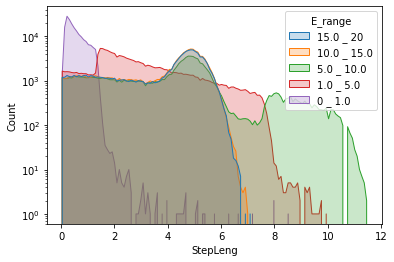

In [13]:
sns.histplot(data, x="StepLeng", hue="E_range", element="poly",log_scale=(False,True))

Here we clearly have the first two energy ranges overlapping and the third others too.
One can distinguish two distributions splitted at E = 7.8 MeV. 

In [14]:
energy_ranges = [7.8, 7.8]
data = map_energy_ranges(data, energy_ranges)

<AxesSubplot:xlabel='StepLeng', ylabel='Count'>

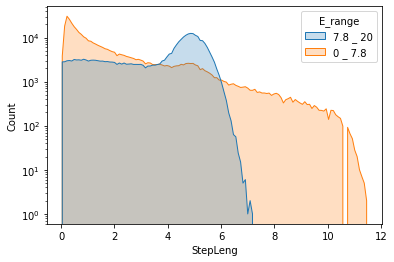

In [15]:
sns.histplot(data, x="StepLeng", hue="E_range", element="poly",log_scale=(False,True))

<AxesSubplot:xlabel='dE(MeV)', ylabel='Count'>

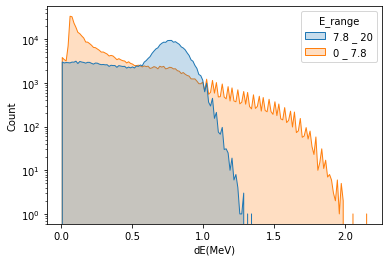

In [16]:
sns.histplot(data, x="dE(MeV)", hue="E_range", element="poly",log_scale=(False,True))

We see that dE and StepLeng are smooth distributions under these energy ranges. We can also study the other parameters

<AxesSubplot:xlabel='cos_theta', ylabel='Count'>

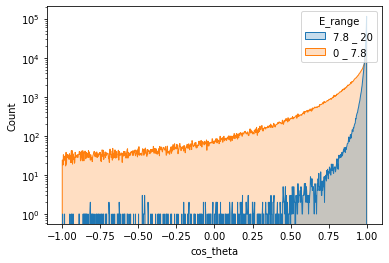

In [17]:
sns.histplot(data, x="cos_theta", hue="E_range", element="poly",log_scale=(False,True))

In [18]:
energy_ranges = [1,5,10,15]
data = map_energy_ranges(data, energy_ranges)

<AxesSubplot:xlabel='cos_theta', ylabel='Count'>

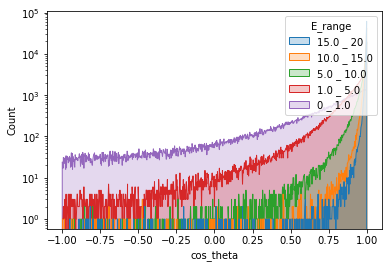

In [19]:
sns.histplot(data, x="cos_theta", hue="E_range", element="poly",log_scale=(False,True))

For cos_theta, the distribution is the same whatever the energy range is.

## Is there energy ranges for emissions ?

In [20]:
data_emission = data.copy(deep = True)

<AxesSubplot:xlabel='KinE(MeV)', ylabel='Density'>

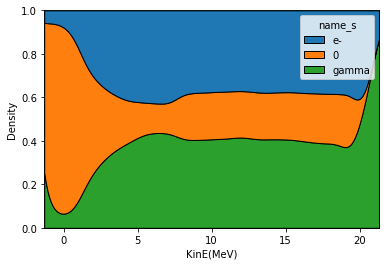

In [21]:
sns.kdeplot(data=data_emission, x="KinE(MeV)", hue="name_s", common_norm=False, multiple="fill", alpha=1)

#### The fact that an initial electron generates a daughter particle depends on the energy of the initial particle. 

Do we need to split the analysis depending on the particle ? The E_range will map every electron into a category range of energy.

In [22]:
data_emission['name_s'] = data_emission['name_s'].apply(type_to_num)

In [23]:
data_0 = data_emission.loc[data_emission['name_s'] == 0]
print(data_0.shape)

(441704, 20)


In [24]:
data_e = data_emission.loc[data_emission['name_s'] == 1]
print(data_e.shape)

(182608, 20)


In [25]:
data_g = data_emission.loc[data_emission['name_s'] == 2]
print(data_g.shape)

(56731, 20)


Text(0.5, 1.0, 'gamma')

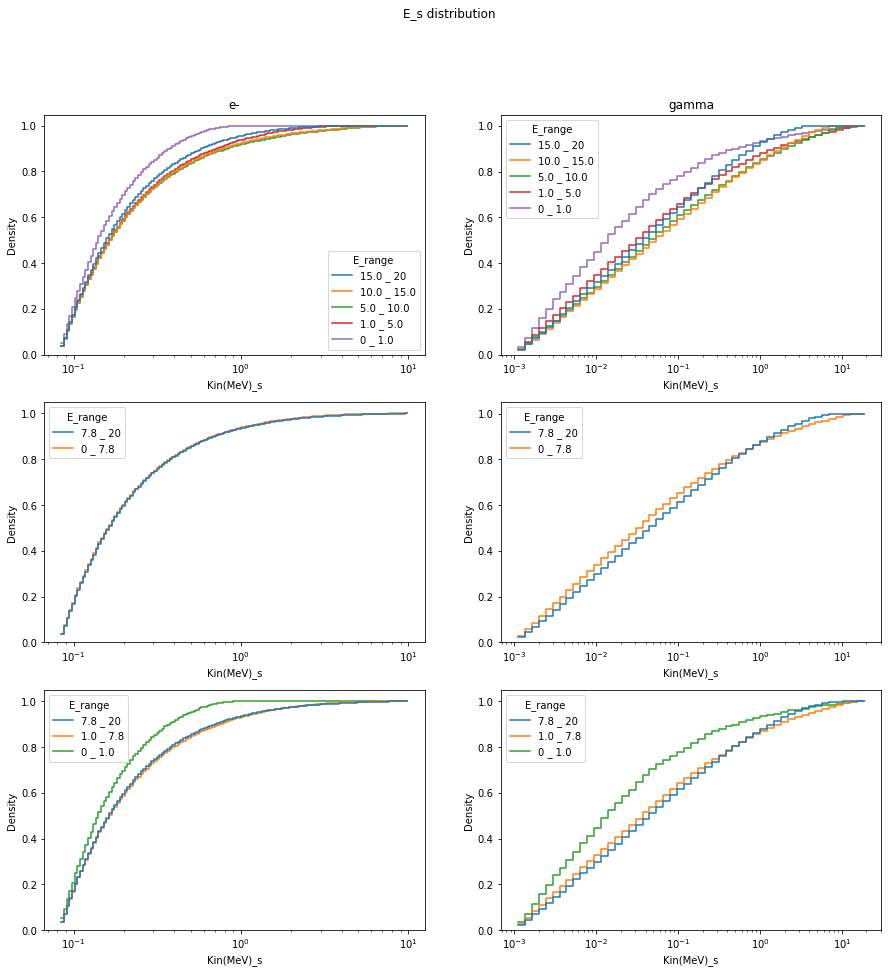

In [26]:
energy_ranges = [1,5,10,15]
data_emission = map_energy_ranges(data_emission, energy_ranges)

data_0 = data_emission.loc[data_emission['name_s'] == 0]
data_e = data_emission.loc[data_emission['name_s'] == 1]
data_g = data_emission.loc[data_emission['name_s'] == 2]


fig, axes = plt.subplots(3, 2, figsize=(15, 15), sharey=False)
fig.suptitle('E_s distribution')

hue_order = data_emission['E_range'].unique().tolist()

# e-
sns.histplot(
    ax=axes[0,0],
    data=data_e, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

# gamma
sns.histplot(
    ax=axes[0,1],
    data=data_g, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

# Now we change the possible range of electron

energy_ranges = [7.8]
data_emission = map_energy_ranges(data_emission, energy_ranges)
data_e = data_emission.loc[data_emission['name_s'] == 1]
data_g = data_emission.loc[data_emission['name_s'] == 2]

hue_order = data_emission['E_range'].unique().tolist()

#e- 
sns.histplot(
    ax=axes[1,0],
    data=data_e, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

# gamma
sns.histplot(
    ax=axes[1,1],
    data=data_g, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

#We change again the ranges

energy_ranges = [1, 7.8]
data_emission = map_energy_ranges(data_emission, energy_ranges)
data_e = data_emission.loc[data_emission['name_s'] == 1]
data_g = data_emission.loc[data_emission['name_s'] == 2]

hue_order = data_emission['E_range'].unique().tolist()

sns.histplot(
    ax=axes[2,0],
    data=data_e, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

# gamma
sns.histplot(
    ax=axes[2,1],
    data=data_g, x="Kin(MeV)_s", hue="E_range",
    hue_order=hue_order,
    log_scale=True, element="step", fill=False,
    cumulative=True, stat="density", common_norm=False,
)

axes[0,0].set_title('e-')
axes[0,1].set_title('gamma')

From this cumulative density plots above, one can conclude that from 0 to 1 MeV for the parent electron, the daughter particle will have lower energies than for Energie ranges from 1 to 20 MeV of the parent. Indeed, the density for low energy range reach higher values (y-axis) for lower values of Kin(MeV)s (x-axis) which corresponds to daughter particle energy. 
From this observation, a good split of energy ranges to predict Kin(MeV)s would be 0-1 MeV and 1-20 MeV but as seen earlier, it is not suited for the other parameters to predict.

### Conclusion of analysis

We will split the dataset onto energy ranges. First, we make a GAN for the electron that do not produce any particle, and a GAN for the electron that produces a particle.

The first GAN will take 2 possible ranges: 0-7.8 MeV and 7.8-20 MeV.

The second GAN will also take 2 possible ranges but different 0-1 MeV and 1-20 MeV.

In [27]:
data_path = data_file(20.0)

In [28]:
data = clean_df(build_df(data_path))

In [29]:
data = data.loc[data['name_s'] != 0]

In [30]:
data = get_angles(data)

In [31]:
data.head()

,index,X(mm),Y(mm),Z(mm),DX,DY,DZ,KinE(MeV),dE(MeV),StepLeng,...,Y(mm)_s,Z(mm)_s,DX_s,DY_s,DZ_s,Kin(MeV)_s,name_s,cos_phi,cos_theta,cos_psi
1,1,4.12,99.8,100.0,0.987,-0.16000,-0.0122,18.40,0.5630,4.120,...,99.8,100.0,0.802,0.592,0.0804,1.0700,e-,0.695873,0.997879,0.645309
2,2,8.26,99.1,100.0,0.974,-0.22700,-0.0181,17.60,0.6210,4.220,...,99.1,100.0,0.506,0.811,-0.2930,0.1190,e-,0.314050,0.985838,0.174330
4,4,14.60,97.8,100.0,0.937,-0.33100,0.1070,11.60,0.3110,1.690,...,97.8,100.0,0.987,0.133,-0.0869,4.8900,e-,0.871498,0.960117,0.729625
6,6,19.50,96.1,101.0,0.829,-0.44400,0.3400,10.60,0.0663,0.593,...,96.1,101.0,0.801,-0.496,0.3350,0.2260,gamma,0.998153,0.826920,0.804041
11,11,34.30,92.3,113.0,0.702,-0.00649,0.7120,7.39,0.0633,0.468,...,92.3,113.0,0.844,0.267,-0.4640,0.0852,e-,0.260387,0.571937,-0.205534


## 1. Prepare torch tensor for ML processing

In [34]:
#We do not take into account the initial energy of the particle
def first_data(df):
    df = df.copy(deep=True)
    df = df.loc[df['name_s'] == 0]
    df = df[['cos_theta','dE(MeV)','StepLeng']]
    df = df.to_numpy()
    return df

In [35]:
data_path = data_file(20.0)

In [36]:
data = first_data(get_cos(clean_df(build_df(data_path))))

In [37]:
data[:5]

array([[0.987     , 0.        , 0.        ],
       [0.98255922, 0.779     , 4.78      ],
       [0.999542  , 0.701     , 4.75      ],
       [0.945264  , 0.7       , 4.35      ],
       [0.984864  , 0.77      , 5.26      ]])

In [38]:
np.isnan(data).sum()

0

In [366]:
def inf_data_gen(dataset=None, batch_size=None):
    """Python infinite iterator (called python-generator) of samples
    following certain distribution.

    Example Usage:
    data_generator = inf_data_gen(dataset='E_20.0.data', batch_size=64)
    sample = next(data_generator)
    """
    while True:
            data = dataset[np.random.choice(dataset.shape[0],\
                                            size=batch_size, replace=False), :]
            data = data.astype("float32")
            yield data  # torch.from_numpy(data)

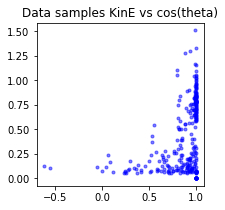

In [367]:
data_generator = inf_data_gen(dataset=data, batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(3, 3))
plt.scatter(sample[:, 0], sample[:, 1], c="blue", marker=".", alpha=0.5)
plt.title("Data samples KinE vs cos(theta)")
plt.show()

In [368]:
# @title Setup
# Learning rate of the generator:
g_lr = 1e-4  # @param {type:"number",  min:0.000001}
# Learning rate of the discriminator:
d_lr = 5e-4  # @param {type:"number",  min:0.000001}
# batch size:
batch_size = 64  # @param {type:"integer",  min:1}
# dimension of tha latent vector
noise_dim = 100  # @param {type:"integer",  min:1}
# number of training iterations
total_iterations = 5000  # @param {type:"slider", min:1, max:50000, step:1}

In [369]:
# @title Loss & GAN architecture: define MLPs for th Generator & the Discriminator
import torch.nn as nn



class GeneratorMLP(nn.Module):
    def __init__(self, dim_hidden=512, dim_out=3, noise_dim=100):
        super(GeneratorMLP, self).__init__()
        self.dim_hidden = dim_hidden
        self.dim_out = dim_out
        self.noise_dim = noise_dim
        self.net = nn.Sequential(
            nn.Linear(noise_dim, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_out),
        )

    def forward(self, x):
        return self.net(x)


class DiscriminatorMLP(nn.Module):
    def __init__(self, dim_hidden=512, dim_gen_out=3):
        super(DiscriminatorMLP, self).__init__()
        self.dim_hidden = dim_hidden
        self.dim_gen_out = dim_gen_out
        self.net = nn.Sequential(
            nn.Linear(dim_gen_out, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, dim_hidden),
            nn.LeakyReLU(inplace=True),
            nn.Linear(dim_hidden, 1),
            nn.Sigmoid(),
        )

    def forward(self, x, labels):
        embedding = self.embed(labels)
        return self.net(x)



GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=512, out_features=3, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=3, out_features=512, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=512, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [375]:
import numpy as np, queue, pylab as plt, random, sys, enum, math

In [378]:
# @title train & store fake samples throughout training

if torch.cuda.is_available():
    g_model = g_model.cuda()
    d_model = d_model.cuda()
    criterion = criterion.cuda()
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
g_optim = torch.optim.Adam(g_model.parameters(), lr=g_lr, betas=(0.5, 0.999))
d_optim = torch.optim.Adam(d_model.parameters(), lr=d_lr, betas=(0.5, 0.999))

generator = {"model": g_model, "optim": g_optim}
discriminator = {"model": d_model, "optim": d_optim}

fixed_noise = torch.randn(300, noise_dim, device=device)
data_generator = inf_data_gen(dataset=data, batch_size=batch_size)

plot_frequency = total_iterations // 100
fake_samples = []
DONE=0
for i in range(total_iterations):
    train_discriminator(
        generator,
        discriminator,
        data_sampler=data_generator,
        loss=criterion,
        batch_size=batch_size,
        device=device,
    )

    train_generator(
        generator, discriminator, loss=criterion, batch_size=batch_size, device=device
    )
    if (i%100 == 0) :
            sys.stdout.write(f"Finished {i:8} out of {total_iterations:8} {(100.0*i)/total_iterations:.2f} %\r"); sys.stdout.flush()

    if i % plot_frequency == 0 or (i + 1) == total_iterations:
        fake_samples.append(generator["model"](fixed_noise).cpu().detach().numpy())

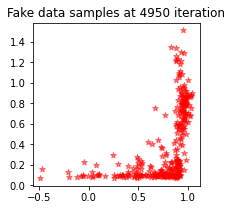

In [395]:
# @title Plot fake samples: select the iteration (0 and 100 are at begining and end of training, resp.)
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}

fake_sample = fake_samples[iteration_plot_generator_samples]
plt.figure(figsize=(3, 3))
plt.scatter(fake_sample[:, 0], fake_sample[:, 1], c="red", marker="*", alpha=0.5)
plt.title(
    f"Fake data samples at {iteration_plot_generator_samples*plot_frequency} iteration"
)
plt.show()

In [1]:
len(fake_sample)

NameError: name 'fake_sample' is not defined

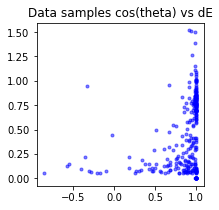

In [397]:
data_generator = inf_data_gen(dataset=data, batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(3, 3))
plt.scatter(sample[:, 0], sample[:, 1], c="blue", marker=".", alpha=0.5)
plt.title("Data samples cos(theta) vs dE")
plt.show()

In [76]:
from GAN_function import *

## Let's train every GAN
First GAN : dataset = no-emission  and  $0< E<7.8$ MeV.

In [4]:
data_path = data_file(20.0)

In [34]:
data1, data2 = GAN1_data(data_path)

Dataset is loaded and ready for process, let's see what to expect for different variables.

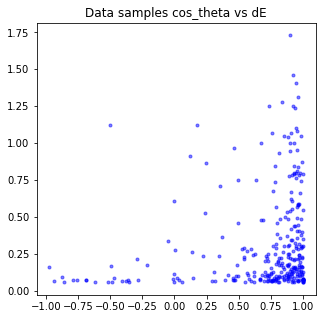

In [58]:
# ID for each variable
name_var = {'cos_theta': 0, 'dE': 1}

# What variable to plot

var_x = 'cos_theta'
var_y = 'dE'
plot_x = name_var[var_x]
plot_y = name_var[var_y]


data_generator = inf_data_gen(dataset=data1, batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(5, 5))
plt.scatter(sample[:, plot_x], sample[:, plot_y], c="blue", marker=".", alpha=0.5)
plt.title("Data samples " + var_x + " vs " + var_y)
plt.show()

In [11]:
g_lr = 1e-4  # @param {type:"number",  min:0.000001}
# Learning rate of the discriminator:
d_lr = 5e-4  # @param {type:"number",  min:0.000001}
# batch size:
batch_size = 64  # @param {type:"integer",  min:1}
# dimension of tha latent vector
noise_dim = 100  # @param {type:"integer",  min:1}
# number of training iterations
total_iterations = 5000  # @param {type:"slider", min:1, max:50000, step:1}

criterion = nn.BCELoss()  # Binary cross entropy

g_model = GeneratorMLP(dim_hidden=128, dim_out=2, noise_dim=noise_dim)
d_model = DiscriminatorMLP(dim_hidden=128, dim_gen_out=2)
print(g_model)
print(d_model)

GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=2, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [42]:
fake_samples1 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data1,\
                          g_model=g_model, d_model=d_model)

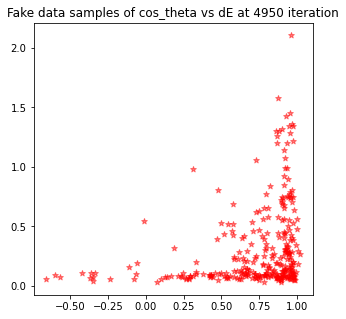

In [61]:
# ID for each variable
name_var = {'cos_theta': 0, 'dE': 1}

# What variable to plot

var_x = 'cos_theta'
var_y = 'dE'
plot_x = name_var[var_x]
plot_y = name_var[var_y]

plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples1[iteration_plot_generator_samples]
plt.figure(figsize=(5, 5))
plt.scatter(fake_sample[:, plot_x], fake_sample[:, plot_y], c="red", marker="*", alpha=0.5)
plt.title(
    f"Fake data samples of {var_x} vs {var_y} at {iteration_plot_generator_samples*plot_frequency} iteration"
)
plt.show()

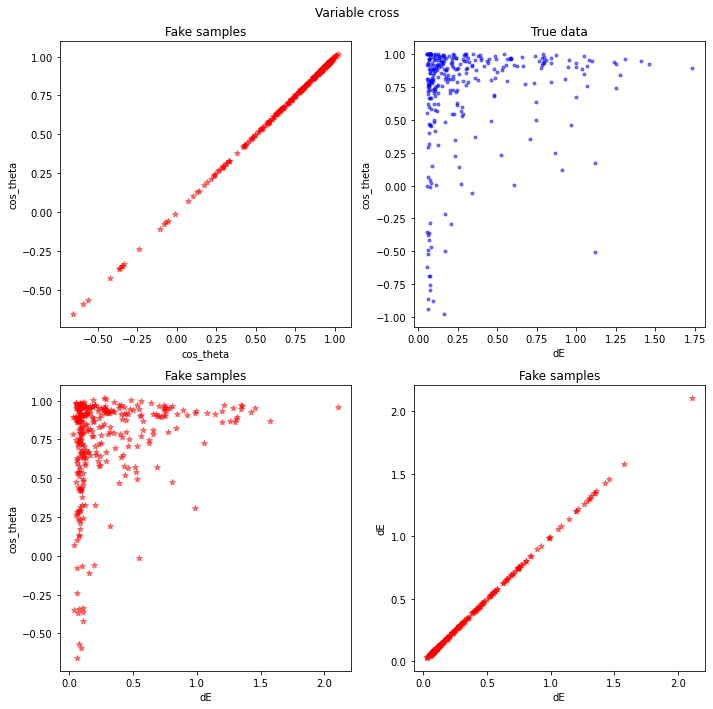

In [91]:
name_var = {'cos_theta': 0, 'dE': 1}
list_name = list(name_var)

N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## Now the SECOND DAN
Second GAN : dataset = no-emission  and  $7.8< E<20$ MeV.

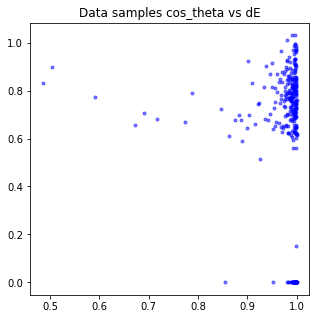

In [92]:
# ID for each variable
name_var = {'cos_theta': 0, 'dE': 1}

# What variable to plot

var_x = 'cos_theta'
var_y = 'dE'
plot_x = name_var[var_x]
plot_y = name_var[var_y]

# This time data2
data_generator = inf_data_gen(dataset=data2, batch_size=300)
sample = next(data_generator)
plt.figure(figsize=(5, 5))
plt.scatter(sample[:, plot_x], sample[:, plot_y], c="blue", marker=".", alpha=0.5)
plt.title("Data samples " + var_x + " vs " + var_y)
plt.show()

We launch the GAN with the corresponding dataset

In [93]:
fake_samples2 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data2,\
                          g_model=g_model, d_model=d_model)

We plot the different variables it predicts

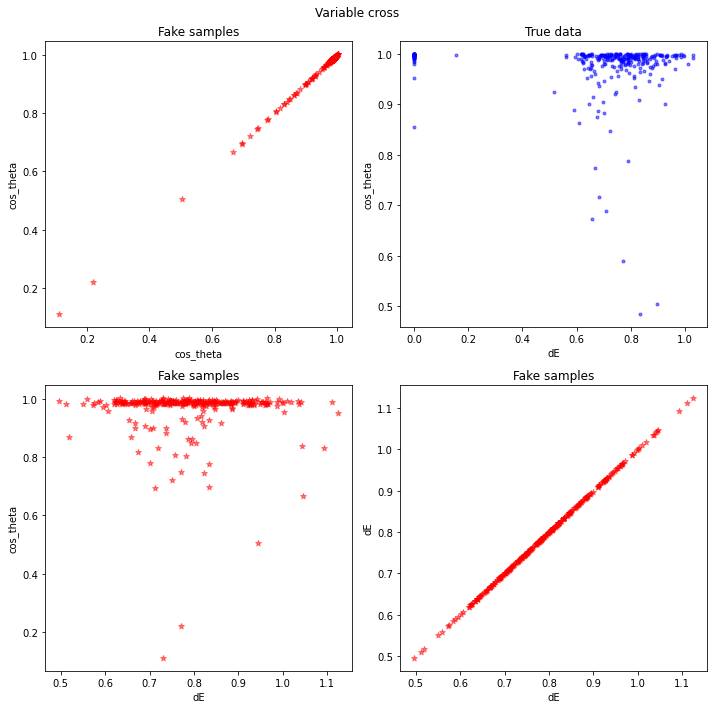

In [95]:
name_var = {'cos_theta': 0, 'dE': 1}
list_name = list(name_var)

plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples2[iteration_plot_generator_samples]

N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## Now the THIRD GAN
Third GAN : dataset = e- emission  and  $0< E<1$ MeV.

In [5]:
data3, data4 = GAN2_data(data_path)

In [6]:
data_generator = inf_data_gen(dataset=data3, batch_size=300)
sample = next(data_generator)

In [7]:
data3[:3]

array([[ 0.4518004,  0.118    ,  0.233566 , -0.576599 ,  0.896    ],
       [-0.6773574,  0.134    ,  0.2839167, -0.775459 ,  0.47     ],
       [ 0.7547224,  0.206    ,  0.3286638,  0.797408 ,  0.84     ]])

In [8]:
name_var = {'cos_theta': 0, 'dE': 1, 'cos_phi': 2, 'cos_psi': 3, 'E_s': 4}
list_name = list(name_var)

In [9]:
dim_out = len(list_name)

In [12]:
g_model2 = GeneratorMLP(dim_hidden=128, dim_out=dim_out, noise_dim=noise_dim)
d_model2 = DiscriminatorMLP(dim_hidden=128, dim_gen_out=dim_out)
print(g_model2)
print(d_model2)

GeneratorMLP(
  (net): Sequential(
    (0): Linear(in_features=100, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=5, bias=True)
  )
)
DiscriminatorMLP(
  (net): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): LeakyReLU(negative_slope=0.01, inplace=True)
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


In [13]:
fake_samples3 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data3,\
                          g_model=g_model2, d_model=d_model2)

In [14]:
plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples3[iteration_plot_generator_samples]

In [15]:
# Build dataframe for seaborn plot

fake_df = pd.DataFrame(columns=list_name,data=fake_sample)
true_df = pd.DataFrame(columns=list_name,data=sample)

In [16]:
true_df.head()

,cos_theta,dE,cos_phi,cos_psi,E_s
0,-0.394013,0.0750,0.127820,0.286925,0.164
1,-0.180968,0.2060,0.353306,-0.149985,0.835
2,0.381605,0.1830,0.223805,0.520638,0.970
3,0.678357,0.1130,0.182634,0.549764,0.582
4,0.647996,0.0767,0.294188,0.748203,0.865


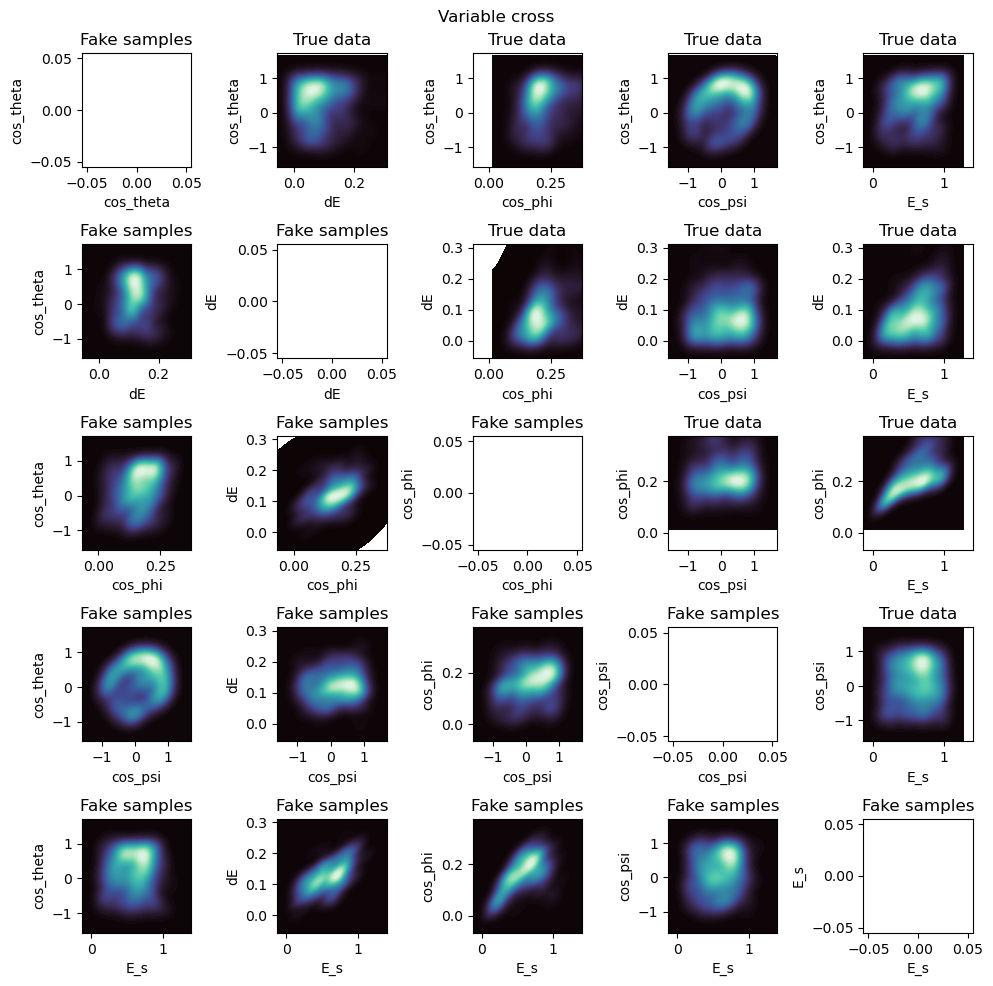

In [21]:
N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            #sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        #cmap="Reds", shade=True)
            sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            sns.kdeplot(data=true_df, ax=axs[i,j], x=list_name[j], y=list_name[i],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].sharex(axs[j,i])
            axs[i,j].sharey(axs[j,i])
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## Now the FOURTH GAN
Fourth GAN : dataset = e- emission  and  $1< E<20$ MeV.

In [22]:
data_generator = inf_data_gen(dataset=data4, batch_size=300)
sample = next(data_generator)

In [23]:
data4[:3]

array([[ 0.99787882,  0.563     ,  0.69587312,  0.64530876, 18.4       ],
       [ 0.9858383 ,  0.621     ,  0.3140503 ,  0.17433   , 17.6       ],
       [ 0.73610619,  0.311     ,  0.8714977 ,  0.63013803, 11.6       ]])

In [24]:
name_var = {'cos_theta': 0, 'dE': 1, 'cos_phi': 2, 'cos_psi': 3, 'E_s': 4}
list_name = list(name_var)

In [25]:
dim_out = len(list_name)

In [26]:
fake_samples4 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data4,\
                          g_model=g_model2, d_model=d_model2)

In [72]:
u = fake_samples4[0]

In [73]:
len(u)

300

In [74]:
u[0]

array([ 0.5244988 ,  0.1317743 ,  0.1923932 , -0.28010044,  0.9532435 ],
      dtype=float32)

In [14]:
plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples4[iteration_plot_generator_samples]

In [15]:
# Build dataframe for seaborn plot

fake_df = pd.DataFrame(columns=list_name,data=fake_sample)
true_df = pd.DataFrame(columns=list_name,data=sample)

In [16]:
true_df.head()

,cos_theta,dE,cos_phi,cos_psi,E_s
0,-0.394013,0.0750,0.127820,0.286925,0.164
1,-0.180968,0.2060,0.353306,-0.149985,0.835
2,0.381605,0.1830,0.223805,0.520638,0.970
3,0.678357,0.1130,0.182634,0.549764,0.582
4,0.647996,0.0767,0.294188,0.748203,0.865


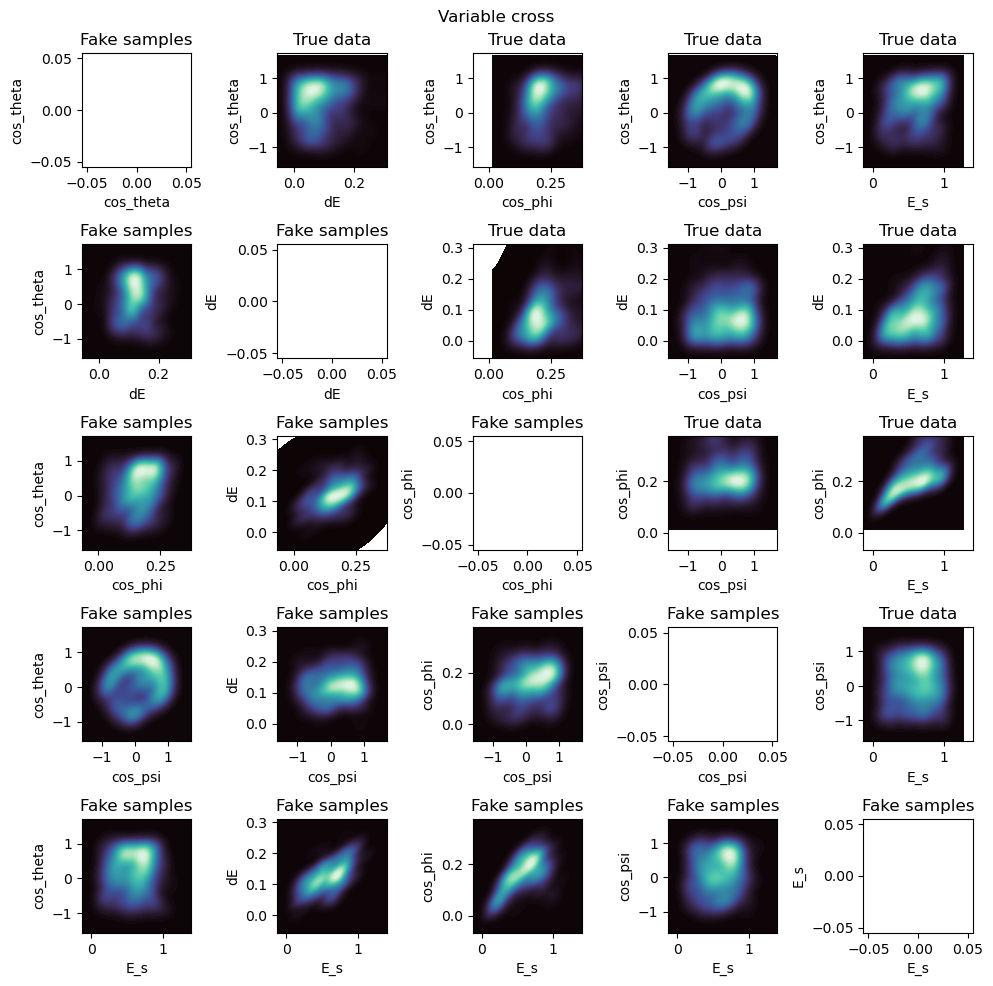

In [21]:
N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            #sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        #cmap="Reds", shade=True)
            sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            sns.kdeplot(data=true_df, ax=axs[i,j], x=list_name[j], y=list_name[i],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].sharex(axs[j,i])
            axs[i,j].sharey(axs[j,i])
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## Now the FIFTH GAN
Fifth GAN : dataset = gamma emission  and  $0< E<1$ MeV.

In [49]:
data5, data6 = GAN3_data(data_path)

In [50]:
data_generator = inf_data_gen(dataset=data5, batch_size=300)
sample = next(data_generator)

In [51]:
data5[:3]

array([[ 0.86376311,  0.0382    , -0.1339375 ,  0.16758408,  0.0951    ],
       [ 0.0913168 ,  0.00547   , -0.497036  , -0.2005468 ,  0.803     ],
       [ 0.0469857 ,  0.181     ,  0.770568  ,  0.472407  ,  0.632     ]])

In [52]:
name_var = {'cos_theta': 0, 'dE': 1, 'cos_phi': 2, 'cos_psi': 3, 'E_s': 4}
list_name = list(name_var)

In [53]:
dim_out = len(list_name)

In [54]:
fake_samples5 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data5,\
                          g_model=g_model2, d_model=d_model2)

In [55]:
plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples5[iteration_plot_generator_samples]

In [56]:
# Build dataframe for seaborn plot

fake_df = pd.DataFrame(columns=list_name,data=fake_sample)
true_df = pd.DataFrame(columns=list_name,data=sample)

In [57]:
true_df.head()

,cos_theta,dE,cos_phi,cos_psi,E_s
0,-0.234666,0.01760,0.744090,-0.287827,0.102
1,0.013173,0.10900,0.837111,0.398738,0.801
2,0.955542,0.02910,0.728927,0.582968,0.397
3,-0.098081,0.12300,-0.959546,0.150325,0.508
4,0.368886,0.00832,0.035090,-0.815742,0.148


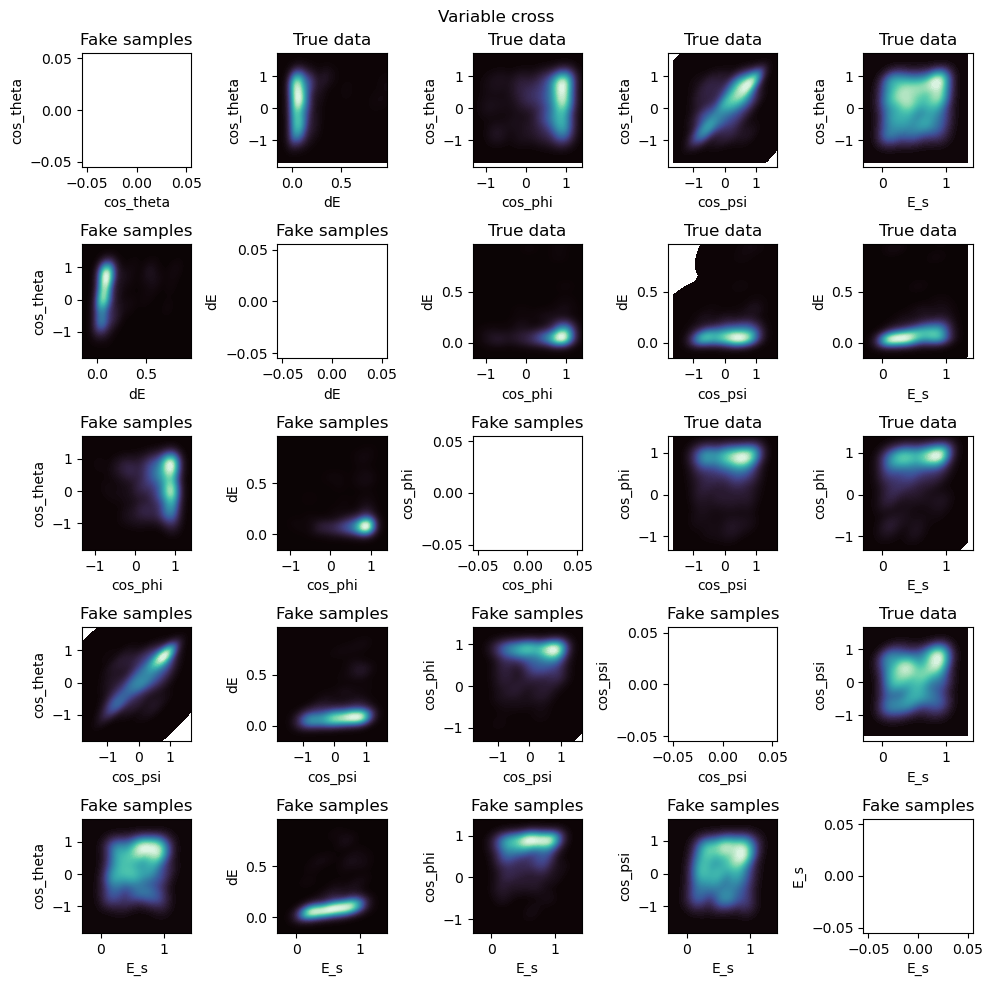

In [58]:
N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            #sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        #cmap="Reds", shade=True)
            sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            sns.kdeplot(data=true_df, ax=axs[i,j], x=list_name[j], y=list_name[i],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].sharex(axs[j,i])
            axs[i,j].sharey(axs[j,i])
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

## Now the SIXTH GAN
Sixth GAN : dataset = gamma emission  and  $1< E<20$ MeV.

In [59]:
data_generator = inf_data_gen(dataset=data6, batch_size=300)
sample = next(data_generator)

In [60]:
data6[:3]

array([[ 0.774428  ,  0.0663    ,  0.998153  ,  0.805832  , 10.6       ],
       [ 0.3477876 ,  0.259     ,  0.246152  ,  0.7851132 ,  3.07      ],
       [ 0.99846401,  0.368     ,  0.9641222 ,  0.95672234, 11.5       ]])

In [61]:
name_var = {'cos_theta': 0, 'dE': 1, 'cos_phi': 2, 'cos_psi': 3, 'E_s': 4}
list_name = list(name_var)

In [62]:
dim_out = len(list_name)

In [63]:
fake_samples6 = launch_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data6,\
                          g_model=g_model2, d_model=d_model2)

In [64]:
plot_frequency = total_iterations // 100
iteration_plot_generator_samples = 99  # @param {type:"slider", min:0, max:100, step:1}
fake_sample = fake_samples6[iteration_plot_generator_samples]

In [65]:
# Build dataframe for seaborn plot

fake_df = pd.DataFrame(columns=list_name,data=fake_sample)
true_df = pd.DataFrame(columns=list_name,data=sample)

In [66]:
true_df.head()

,cos_theta,dE,cos_phi,cos_psi,E_s
0,0.902958,0.3620,1.000332,0.912464,8.230000
1,0.964795,0.0286,0.996454,0.941107,18.700001
2,0.996311,0.1800,0.998466,0.995759,9.620000
3,0.950196,0.2090,0.999016,0.939250,14.100000
4,0.477136,0.0247,0.933237,0.488954,3.110000


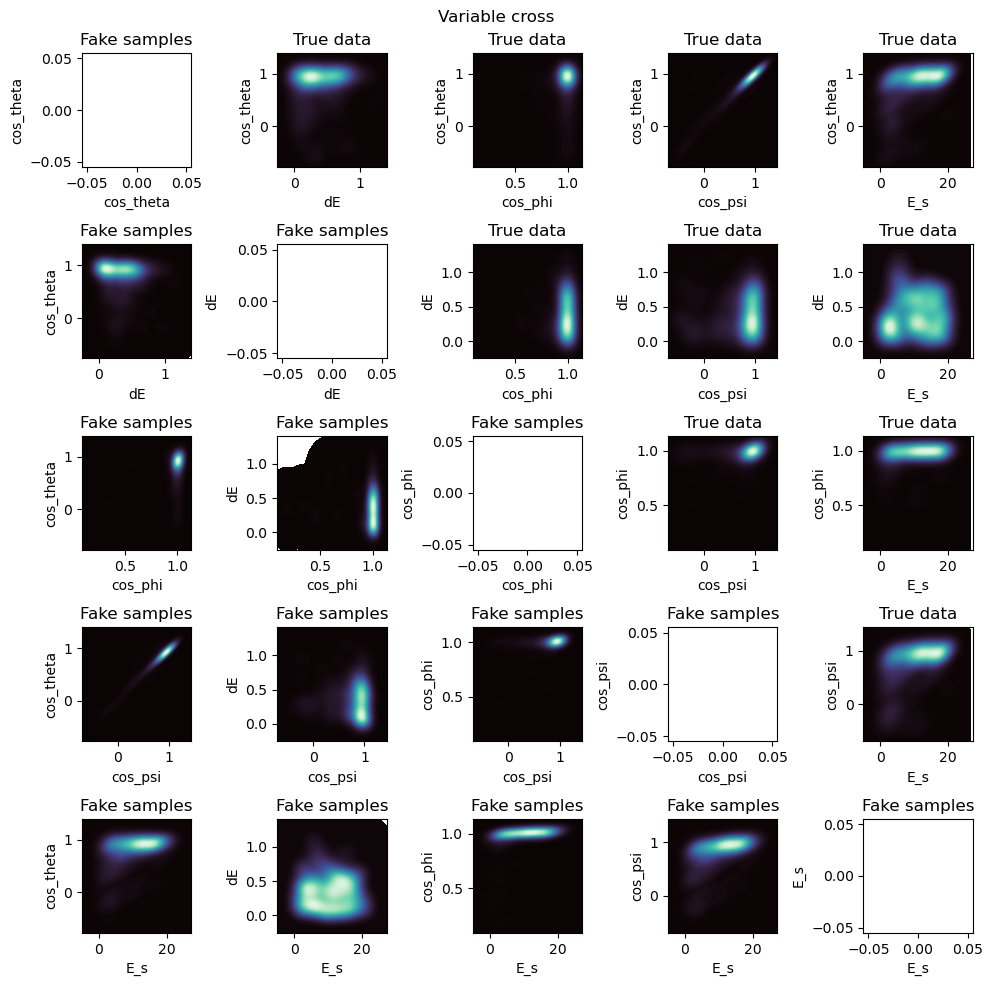

In [67]:
N_variable = fake_sample.shape[1]
fig, axs = plt.subplots(N_variable, N_variable, figsize=(10, 10))
fig.suptitle('Variable cross')
for j in range(N_variable):
    for i in range(N_variable):
        if i >= j:
            #sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        #cmap="Reds", shade=True)
            sns.kdeplot(data=fake_df, ax=axs[i,j], x=list_name[i], y=list_name[j],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(fake_sample[:,i], fake_sample[:,j], c="red", marker="*", alpha=0.5)
            axs[i,j].set_xlabel(list_name[i])
            axs[i,j].set_ylabel(list_name[j])
            axs[i,j].set_title('Fake samples')
        else:
            sns.kdeplot(data=true_df, ax=axs[i,j], x=list_name[j], y=list_name[i],\
                        fill=True, thresh=0, levels=100, cmap="mako",warn_singular=False,)
            #axs[i,j].scatter(sample[:, j], sample[:, i], c="blue", marker=".", alpha=0.5)
            axs[i,j].sharex(axs[j,i])
            axs[i,j].sharey(axs[j,i])
            axs[i,j].set_xlabel(list_name[j])
            axs[i,j].set_ylabel(list_name[i])
            axs[i,j].set_title('True data')
fig.tight_layout(pad=1)

Trying to create a new event

In [78]:
g_model2 = train_GAN(g_lr=g_lr, d_lr=d_lr, batch_size=batch_size, noise_dim=noise_dim,\
                          total_iterations=total_iterations, criterion=criterion, data=data6,\
                          g_model=g_model2, d_model=d_model2)

In [1]:
from GAN_function import *

In [2]:
PATH = 'saved_model/model1'

In [3]:
gmodel = GeneratorMLP(dim_hidden=128, dim_out=2, noise_dim=100)
gmodel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [4]:
u = Get_GAN_event(gmodel)

In [5]:
u

array([[0.4836943 , 0.07806079]], dtype=float32)